# Hands-on Deep Learning for Materials 

## *Using deep learning to estimate solubility for organic molecules*

The solubility of materials is crucial to pharmaceutical applications such as formulating novel drugs. In this notebook, you will learn how to train deep learning models to predict the aqueous solubility of organic materials given their composition. 

The composition will be specified as SMILES strings, which are a convenient way to represent the structure of organic materials. You can learn more about SMILES strings [here](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system). We will use these SMILES strings as inputs to a [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) and predict the solubility of organic materials. We will also learn how to train [variational autoencoders](https://www.jeremyjordan.me/variational-autoencoders/) to learn SMILES string representations. Variational autoencoders are models used to learn low-dimensional representations of a high-dimensional dataset, and in our case these models will give us a low-dimensional numerical representation of a SMILES string, which can replace the sparse matrices often used to represent data when using convolutional neural networks.


### Outline of this notebook:
#### _Load and pre-process training data_ 
- Load solubility dataset containing many organic molecules and their associated solubilities
- Pre-process data and split to test/train sets

#### _Train a Convolutional neural network (CNN)_ 
- Train a CNN to predict solubility
- Predict solubility from any given SMILES representation of a molecule 

#### _Train a Variational autoencoder (VAE)_
- Train a VAE to take an encoded SMILES as input and learn a mapping from encoded SMILES to latent space and back to the input
- Use a portion of the VAE to generate SMILES by sampling from a unit gaussian


This notebook is a hands-on demo of *Deep learning for materials and chemicals*. This tutorial uses Python, some familiarity with programming would be beneficial but is not required. Run each code cell in order by clicking "Shift + Enter". Feel free to modify the code or change queries to familiarize yourself with the code.

## <ins>Let's start</ins> 

We'll start with required imports. These includes the [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org/) libraries for the neural network models, [Pandas](https://pandas.pydata.org/) and [Numpy](https://numpy.org/) to process data, as well as other relevant Python libraries.

In [1]:
from __future__ import print_function
# general imports
%matplotlib inline
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 
import keras
from keras import initializers
from keras.layers import Dense
from keras.models import Sequential
from keras import optimizers
from keras import regularizers
import pandas as pd
import seaborn as sns
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.express as px
import numpy as np
import csv
import copy
import random


#import pymatgen as pymat
#import mendeleev as mendel
from subprocess import call
import gzip

from scipy.stats import norm
from IPython.display import HTML

# keras imports
from keras.layers import (Input, Dense, Conv1D, MaxPool1D, Dropout, GRU, LSTM, TimeDistributed, Add, Flatten, RepeatVector, Lambda, Concatenate)
from keras.models import Model, load_model
from keras.metrics import binary_crossentropy
from keras import initializers, regularizers
from keras.callbacks import EarlyStopping
import keras.backend as K

# Visualization
from keras_sequential_ascii import keras2ascii


# from utils import label_map_util
# from utils import visualization_utils as vis_util

#from object_detection.utils import label_map_util
#from object_detection.utils import visualization_utils as vis_util

# utils functions
#from python_utils import *
from utils import *

# Hacky MacOS fix for Tensorflow runtimes... (You won't need this unless you are on MacOS)
# This fixes a display bug with progress bars that can pop up on MacOS sometimes.
#import sys
#import os
#sys.path.insert(0, '../src/')

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Remove warnings from output
import warnings
warnings.filterwarnings('ignore')

#!python -m pip install --user numpy --upgrade
#!python -m pip install --user tensorflow --upgrade
#!python -m pip install --user numpy pycocotools==2.0.0

#!python -V
#import tensorflow as tf
#print(tf.__version__)
#import numpy as np
#print(np.__version__)

Using TensorFlow backend.


# <ins>Load, view, and preprocess dataset</ins> 


We will use the [ESOL dataset](http://moleculenet.ai/datasets-1) to train our models. The ESOL dataset contains the solubility of various small organic molecules. We will begin by loading the dataset as a dataframe and then inspecting some basic metadata. We'll also preprocess the dataset and create train/test splits for the Convolutional Neural Network (CNN) and Variational AutoEncoder (VAE) models. 

In [2]:
#!ls /home/nanohub/bbishnoi/data/results/vae/qm9.csv
#dataset = pd.read_csv("/home/nanohub/bbishnoi/data/results/vae/qm9.csv")
# read dataset as a dataframe
#dataset = pd.read_csv("../data/ESOL_delaney-processed.csv")

from random import shuffle
dataset = pd.read_csv("./qm9.csv")
#dataset = pd.read_csv("gdrive/MyDrive/Colab Notebooks/data/qm9.csv")

# This function randomly arranges the elements so we can have representation for all groups both in the training and testing set
#shuffle(dataset) 

# print column names in dataset
print(f"Columns in dataset: {list(dataset.columns)}")

# print number of rows in dataset
print(f"\nLength of dataset: {len(dataset)}")

# shuffle rows of the dataset (we could do this later as well when doing train/test splits)
dataset = dataset.sample(frac=1, random_state=0)

# show first 5 rows of dataframe
dataset.head()
#dataset.head(20)

Columns in dataset: ['mol_id', 'smiles', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u298', 'h298', 'g298', 'cv', 'u0_atom', 'u298_atom', 'h298_atom', 'g298_atom']

Length of dataset: 133885


,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
43225,gdb_43226,O=C1C2CCCC1C=C2,2.19575,1.83375,1.78978,2.8898,78.73,-0.2330,-0.0029,0.2301,...,0.162755,-385.930699,-385.923667,-385.922723,-385.961801,29.000,-1938.509588,-1950.984467,-1961.653375,-1808.771475
18949,gdb_18950,O=CC1C2C3CC2N13,5.76254,1.67862,1.56959,2.2243,65.83,-0.2456,-0.0355,0.2101,...,0.118824,-362.561835,-362.555470,-362.554526,-362.592646,24.065,-1462.630608,-1471.968569,-1480.266121,-1361.585343
65056,gdb_65057,CC1(CO1)C1(CO1)C#C,2.33460,1.50396,1.24794,2.5230,73.97,-0.2620,0.0181,0.2801,...,0.132144,-421.745993,-421.736936,-421.735992,-421.779716,33.773,-1686.271678,-1695.698118,-1705.181034,-1571.293204
27392,gdb_27393,c1c([nH]c(nc1=O)N)O,2.01530,1.87826,0.97339,7.1395,67.95,-0.2213,0.0039,0.2252,...,0.102825,-470.075554,-470.067765,-470.066821,-470.107671,29.926,-1447.261657,-1454.816238,-1462.520166,-1350.407526
51740,gdb_51741,O=COC1CCC11CN1,2.95255,1.08628,0.88017,2.6332,74.49,-0.2540,0.0016,0.2555,...,0.147164,-439.065902,-439.057354,-439.056409,-439.100076,31.201,-1738.070663,-1748.704431,-1758.779715,-1616.381608


We can explore the range of solubilities found in the dataset by plotting a histogram of solubility values from the dataset. Our machine learning models will aim to predict these solubilities.

In [3]:
#sns.distplot(dataset["measured log solubility in mols per litre"])
df = pd.DataFrame(dataset)
display(df)
df_condition = df[(df['alpha'] < 10) & (df["gap"] > 0.25)]
# "alpha" - Isotropic polarizability (unit: Bohr^3)
# "gap" - Gap between HOMO and LUMO (unit: Hartree)
#"mol_id" - Molecule ID (gdb9 index) mapping to the .sdf file
#"A" - Rotational constant (unit: GHz)
#"B" - Rotational constant (unit: GHz)
#"C" - Rotational constant (unit: GHz)
#"mu" - Dipole moment (unit: D)
#"alpha" - Isotropic polarizability (unit: Bohr^3)
#"homo" - Highest occupied molecular orbital energy (unit: Hartree)
#"lumo" - Lowest unoccupied molecular orbital energy (unit: Hartree)
#"gap" - Gap between HOMO and LUMO (unit: Hartree)
#"r2" - Electronic spatial extent (unit: Bohr^2)
#"zpve" - Zero point vibrational energy (unit: Hartree)
#"u0" - Internal energy at 0K (unit: Hartree)
#"u298" - Internal energy at 298.15K (unit: Hartree)
#"h298" - Enthalpy at 298.15K (unit: Hartree)
#"g298" - Free energy at 298.15K (unit: Hartree)
#"cv" - Heat capacity at 298.15K (unit: cal/(mol*K))
#"u0_atom" - Atomization energy at 0K (unit: kcal/mol)
#"u298_atom" - Atomization energy at 298.15K (unit: kcal/mol)
#"h298_atom" - Atomization enthalpy at 298.15K (unit: kcal/mol)
display(df_condition)
df_homo = df[df.homo.eq(0.26)]
display(df_homo)

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
43225,gdb_43226,O=C1C2CCCC1C=C2,2.19575,1.83375,1.78978,2.8898,78.73,-0.2330,-0.0029,0.2301,...,0.162755,-385.930699,-385.923667,-385.922723,-385.961801,29.000,-1938.509588,-1950.984467,-1961.653375,-1808.771475
18949,gdb_18950,O=CC1C2C3CC2N13,5.76254,1.67862,1.56959,2.2243,65.83,-0.2456,-0.0355,0.2101,...,0.118824,-362.561835,-362.555470,-362.554526,-362.592646,24.065,-1462.630608,-1471.968569,-1480.266121,-1361.585343
65056,gdb_65057,CC1(CO1)C1(CO1)C#C,2.33460,1.50396,1.24794,2.5230,73.97,-0.2620,0.0181,0.2801,...,0.132144,-421.745993,-421.736936,-421.735992,-421.779716,33.773,-1686.271678,-1695.698118,-1705.181034,-1571.293204
27392,gdb_27393,c1c([nH]c(nc1=O)N)O,2.01530,1.87826,0.97339,7.1395,67.95,-0.2213,0.0039,0.2252,...,0.102825,-470.075554,-470.067765,-470.066821,-470.107671,29.926,-1447.261657,-1454.816238,-1462.520166,-1350.407526
51740,gdb_51741,O=COC1CCC11CN1,2.95255,1.08628,0.88017,2.6332,74.49,-0.2540,0.0016,0.2555,...,0.147164,-439.065902,-439.057354,-439.056409,-439.100076,31.201,-1738.070663,-1748.704431,-1758.779715,-1616.381608
76008,gdb_76009,CC1C(C#C)C1(N)C#N,2.53605,1.22419,1.06898,4.3948,81.35,-0.2437,0.0052,0.2489,...,0.133709,-380.832234,-380.822314,-380.821370,-380.866998,35.740,-1716.189424,-1725.074324,-1734.557240,-1601.760021
119004,gdb_119005,CCOC1(C)CCOC1,2.95734,0.99058,0.94789,1.1187,81.84,-0.2415,0.0861,0.3276,...,0.204963,-425.428719,-425.418774,-425.417830,-425.464927,36.697,-2113.660528,-2127.861056,-2140.901948,-1960.128528
113482,gdb_113483,OCC1OC11CC2NC12,4.50687,0.94025,0.93209,2.7993,72.42,-0.2393,0.0653,0.3045,...,0.147184,-439.003744,-438.995489,-438.994544,-439.037024,31.390,-1699.065959,-1709.883586,-1719.958871,-1576.815910
84250,gdb_84251,CC1C=C2CN3CC1C23,3.40650,1.61019,1.39649,1.1495,84.22,-0.2061,-0.0029,0.2033,...,0.173305,-365.940028,-365.932927,-365.931982,-365.971038,29.740,-1932.092681,-1945.412814,-1956.674091,-1795.559273
74040,gdb_74041,CC1=C2CCCC2CC1,2.57908,1.49508,1.01008,0.2143,93.13,-0.2129,0.0320,0.2449,...,0.208230,-351.196235,-351.187674,-351.186730,-351.229269,33.659,-2241.126431,-2256.196687,-2269.237579,-2086.114765


,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
1,gdb_2,N,293.60975,293.54111,191.39397,1.6256,9.46,-0.2570,0.0829,0.3399,...,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
2,gdb_3,O,799.58812,437.90386,282.94545,1.8511,6.31,-0.2928,0.0687,0.3615,...,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171


,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom


In the next cell we will plot a histogram of SMILES string lengths from dataset. These lengths will be used to determine the length of the inputs for our CNN and VAE models. Below are examples of the SMILES representation: 
1. Methane: 'C'
2. Pentane: 'CCCCC'
3. Methanol and Ethanol: 'CO' and 'CCO'
4. Pyridine: 'C1:C:C:N:C:C:1'

To learn more about the SMILES representation, click [here](https://chem.libretexts.org/Courses/University_of_Arkansas_Little_Rock/ChemInformatics_(2017)%3A_Chem_4399%2F%2F5399/2.3%3A_Chemical_Representations_on_Computer%3A_Part_III).

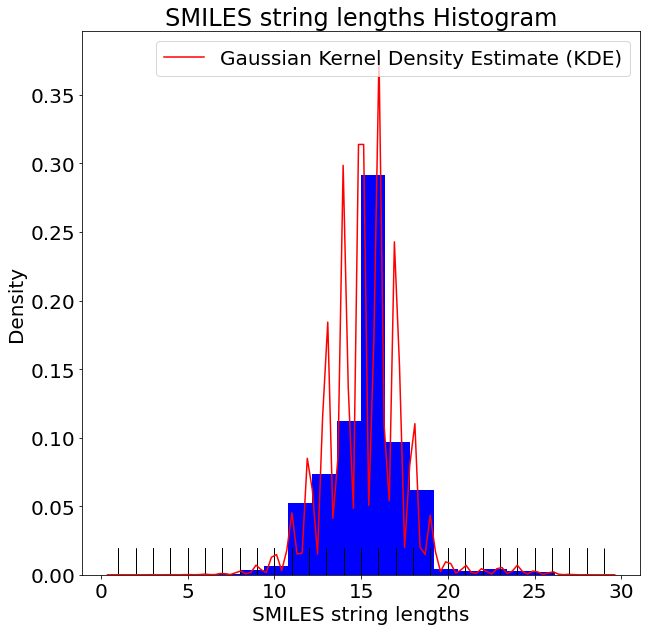

In [4]:
smiles_lengths = map(len, dataset.smiles.values)
#sns.distplot(list(smiles_lengths), bins=20, kde=False)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,10))
plt.title('SMILES string lengths Histogram')
plt.ylabel('Density')
plt.xlabel('SMILES string lengths')
ax = sns.distplot(list(smiles_lengths), color="b", bins=20, rug=True, rug_kws={"color": "k"}, kde=True, kde_kws={"color": "r", "label": "Gaussian Kernel Density Estimate (KDE)"}, hist_kws={"histtype": "bar", "linewidth": 3, "alpha": 1, "color": "b"} )
ax=plt.savefig('./mu_smiles_lengths.png', dpi=600, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format=None,transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None, metadata=None)
#ax=plt.savefig('gdrive/MyDrive/Colab Notebooks/data/fig_smiles_lengths.png', dpi=600, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format=None,transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None, metadata=None)
# ax=plt.savefig('../data/fig_smiles_lengths.png', dpi=600, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format=None,transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None, metadata=None)


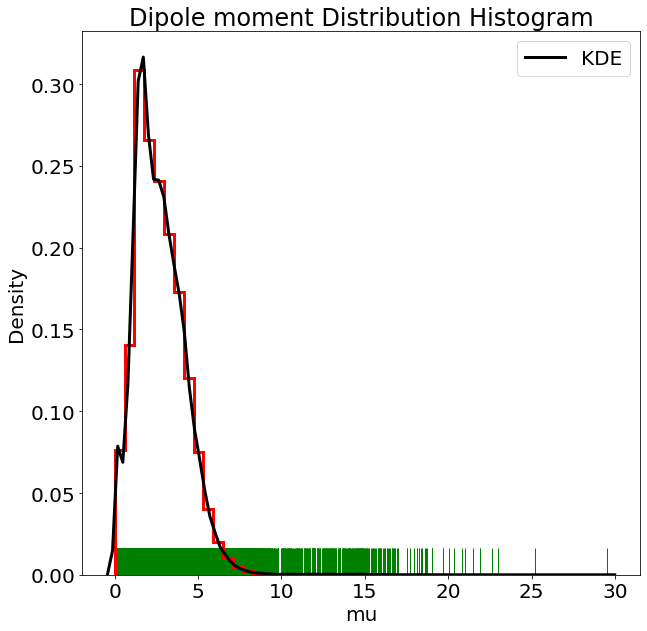

In [5]:
 plt.figure(figsize=(10,10))
 plt.rcParams.update({'font.size': 20})
 smiles_lengths = map(len, dataset.smiles.values)
 #sns.distplot(list(smiles_lengths), bins=20, kde=False
plt.title('Dipole moment Distribution Histogram')
plt.ylabel('Density')
plt.xlabel('Dipole moment (D)')              

# sns.displot(list(smiles_lengths), bins=20, kde=False)
#ax = sns.distplot(dataset["lumo"], rug=True, rug_kws={"color": "g"}, kde_kws={"color": "k", "lw": 3, "label": "KDE"}, hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "g"})
ax = sns.distplot(dataset["mu"], rug=True, rug_kws={"color": "g"},kde_kws={"color": "k", "lw": 3, "label": "KDE"},hist_kws={"histtype":"step", "linewidth": 3,"alpha": 1, "color": "r"})
ax=plt.savefig('./mu.png', dpi=600, facecolor='w', edgecolor='w',orientation='landscape', papertype='a4', format=None, transparent=False, bbox_inches=None, pad_inches=None, frameon=None, metadata=None)


### Data preparation

Now we will pre-process the dataset for the CNN and VAE models. First, we'll get the unique character set from all SMILES strings in the dataset. Then we will use the unique character set to convert our SMILES strings to a one-hot representation, which is a representation that converts raw strings of text to numerical inputs for our models.

In a one-hot representation, each character of our SMILES string is encoded as a vector of zeros, except for one non-zero value. For instance, the character 'C' in the SMILES string is converted to a vector of length 31, consisting of 30 zeros and one non-zero entry of one. The length of this vector (31 in our case) is the total number of unique characters in the dataset.

Given a string of 5 characters (say Pentane, which is represented as 'CCCCC'), we would thus get 5 vectors each of length 31. Since different molecules have different SMILES string lengths, we can pre-define the length of each string to be the maximum length from the database, with smaller molecules represented with additional characters. In our case, this maximum length is 40 and we represent the extra characters for smaller molecules with pre-defined one-hot vectors. This means that each molecule is now represented as a set of 40 vectors, each of length 31. We can represent this as a 40x31 matrix.

One-hot encoding is commonly used in natural language processing, and you can learn more about one-hot encoding [here](https://en.wikipedia.org/wiki/One-hot). 

Finally, we will define our input and output and create test/train splits in the dataset.

In [6]:
charset = generate_charset(
    dataset["smiles"].values.ravel()
)
# get the number of unique characters
charset_length = len(charset)
# define max number of SMILES for model input vector
max_smiles_chars = 40
# dimension of input vector
input_dim = charset_length * max_smiles_chars
# get one-hot representation of the SMILES strings 
one_hots = smiles_to_onehots(dataset["smiles"].values, charset, max_smiles_chars)
# split input into train and test sets
X_train = one_hots[:-13385] #This takes the first 133885-13385=120500  entries to be the Training Set
X_test = one_hots[-13385:] # This takes the last 13385 entries to be the Testing Set

# split output to train and test sets
output = dataset["mu"].values
#output = dataset["homo"].values
#output = dataset["cv"].values
#output = dataset["r2"].values

# "alpha" - Isotropic polarizability (unit: Bohr^3)
# "gap" - Gap between HOMO and LUMO (unit: Hartree)
#"mol_id" - Molecule ID (gdb9 index) mapping to the .sdf file
#"A" - Rotational constant (unit: GHz)
#"B" - Rotational constant (unit: GHz)
#"C" - Rotational constant (unit: GHz)
#"mu" - Dipole moment (unit: D)
#"alpha" - Isotropic polarizability (unit: Bohr^3)
#"homo" - Highest occupied molecular orbital energy (unit: Hartree)
#"lumo" - Lowest unoccupied molecular orbital energy (unit: Hartree)
#"gap" - Gap between HOMO and LUMO (unit: Hartree)
#"r2" - Electronic spatial extent (unit: Bohr^2)
#"zpve" - Zero point vibrational energy (unit: Hartree)
#"u0" - Internal energy at 0K (unit: Hartree)
#"u298" - Internal energy at 298.15K (unit: Hartree)
#"h298" - Enthalpy at 298.15K (unit: Hartree)
#"g298" - Free energy at 298.15K (unit: Hartree)
#"cv" - Heat capavity at 298.15K (unit: cal/(mol*K))
#"u0_atom" - Atomization energy at 0K (unit: kcal/mol)
#"u298_atom" - Atomization energy at 298.15K (unit: kcal/mol)
#"h298_atom" - Atomization enthalpy at 298.15K (unit: kcal/mol)
Y_train = output[:-13385] #This takes the first 133885-100=133785 entries to be the Training Set
Y_test = output[-13385:] # This takes the last 100 entries to be the Testing Set

# This Reshape function in the next two lines, turns each of the horizontal lists [ x, y, z] into a
# vertical NumPy array [[x]
#                       [y]
#                       [z]]
# This Step is required to work with the Sklearn Linear Model
#Y_train = np.array(melt_train).reshape(-1,1) 
#Y_test  = np.array(melt_test).reshape(-1,1)
print(len(X_train),len(X_test),len(Y_train),len(Y_test))
# print(X_train[0]) # print a sample entry from the training set
# print(X_test[0]) # print a sample entry from the training set
# print(order)


##  Train-Test Split  ##
# https://proxy.nanohub.org/weber/1914019/IVqSH6gE0f3W6g9X/5/notebooks/mldefect.ipynb?
# XX = copy.deepcopy(X)
# n = dopant.size
# m = np.int(X.size/n)

# print(n)
# print(m)

# t = 0.20

# X_train, X_test, Prop_train, Prop_test, dop_train, dop_test, sc_train, sc_test, ds_train, ds_test = train_test_split(XX, prop, dopant, CdX, doping_site, test_size=t)

# n_tr = Prop_train.size
# n_te = Prop_test.size

# print(n_tr)
# print(n_te)

# Prop_train_fl = np.zeros(n_tr)
# for i in range(0,n_tr):
#     Prop_train_fl[i] = copy.deepcopy(float(Prop_train[i]))
    
# print(Prop_train_fl)

# Prop_test_fl = np.zeros(n_te)
# for i in range(0,n_te):
#     Prop_test_fl[i] = copy.deepcopy(float(Prop_test[i]))
    
# print(Prop_test_fl)
    
# X_train_fl = [[0.0 for a in range(m)] for b in range(n_tr)]
# for i in range(0,n_tr):
#     for j in range(0,m):
#         X_train_fl[i][j] = np.float(X_train[i][j])

# print(X_train_fl)

# X_test_fl = [[0.0 for a in range(m)] for b in range(n_te)]
# for i in range(0,n_te):
#     for j in range(0,m):
#         X_test_fl[i][j] = np.float(X_test[i][j])

# print(X_test_fl)

# X_out_fl = [[0.0 for a in range(m)] for b in range(n_out)]
# for i in range(0,n_out):
#     for j in range(0,m):
#         X_out_fl[i][j] = np.float(X_out[i][j])

# print(X_out_fl)

# X_all_fl = [[0.0 for a in range(m)] for b in range(n_all)]
# for i in range(0,n_all):
#     for j in range(0,m):
#         X_all_fl[i][j] = np.float(X_all[i][j])

# print(X_all_fl)

120500 13385 120500 13385


Let's briefly visualize what our input data looks like using a heatmap that shows the position of each character in the SMILES string, you can change the index to see various molecules. Each molecule is represented by a 40x31 sparse matrix, the bright spots in the heatmap indicate the position at which a one is found in the matrix. For instance, the first row has a bright spot at index 18, indicating that the first character is 'C'. The second row has a bright spot at index 23, which indicates that the second character is 'O'. For the compound Dimethoxymethane with a SMILES string 'COCOC', we expect the matrix to have alternating bright spots at index 18 and index 23 for the first five rows. Beyond that, the rows all have a bright spot at index 1, which stands for the extra characters padded on to our string to make all SMILES strings the same length. The heatmap below is plotted using the [Seaborn](https://seaborn.pydata.org/) library.

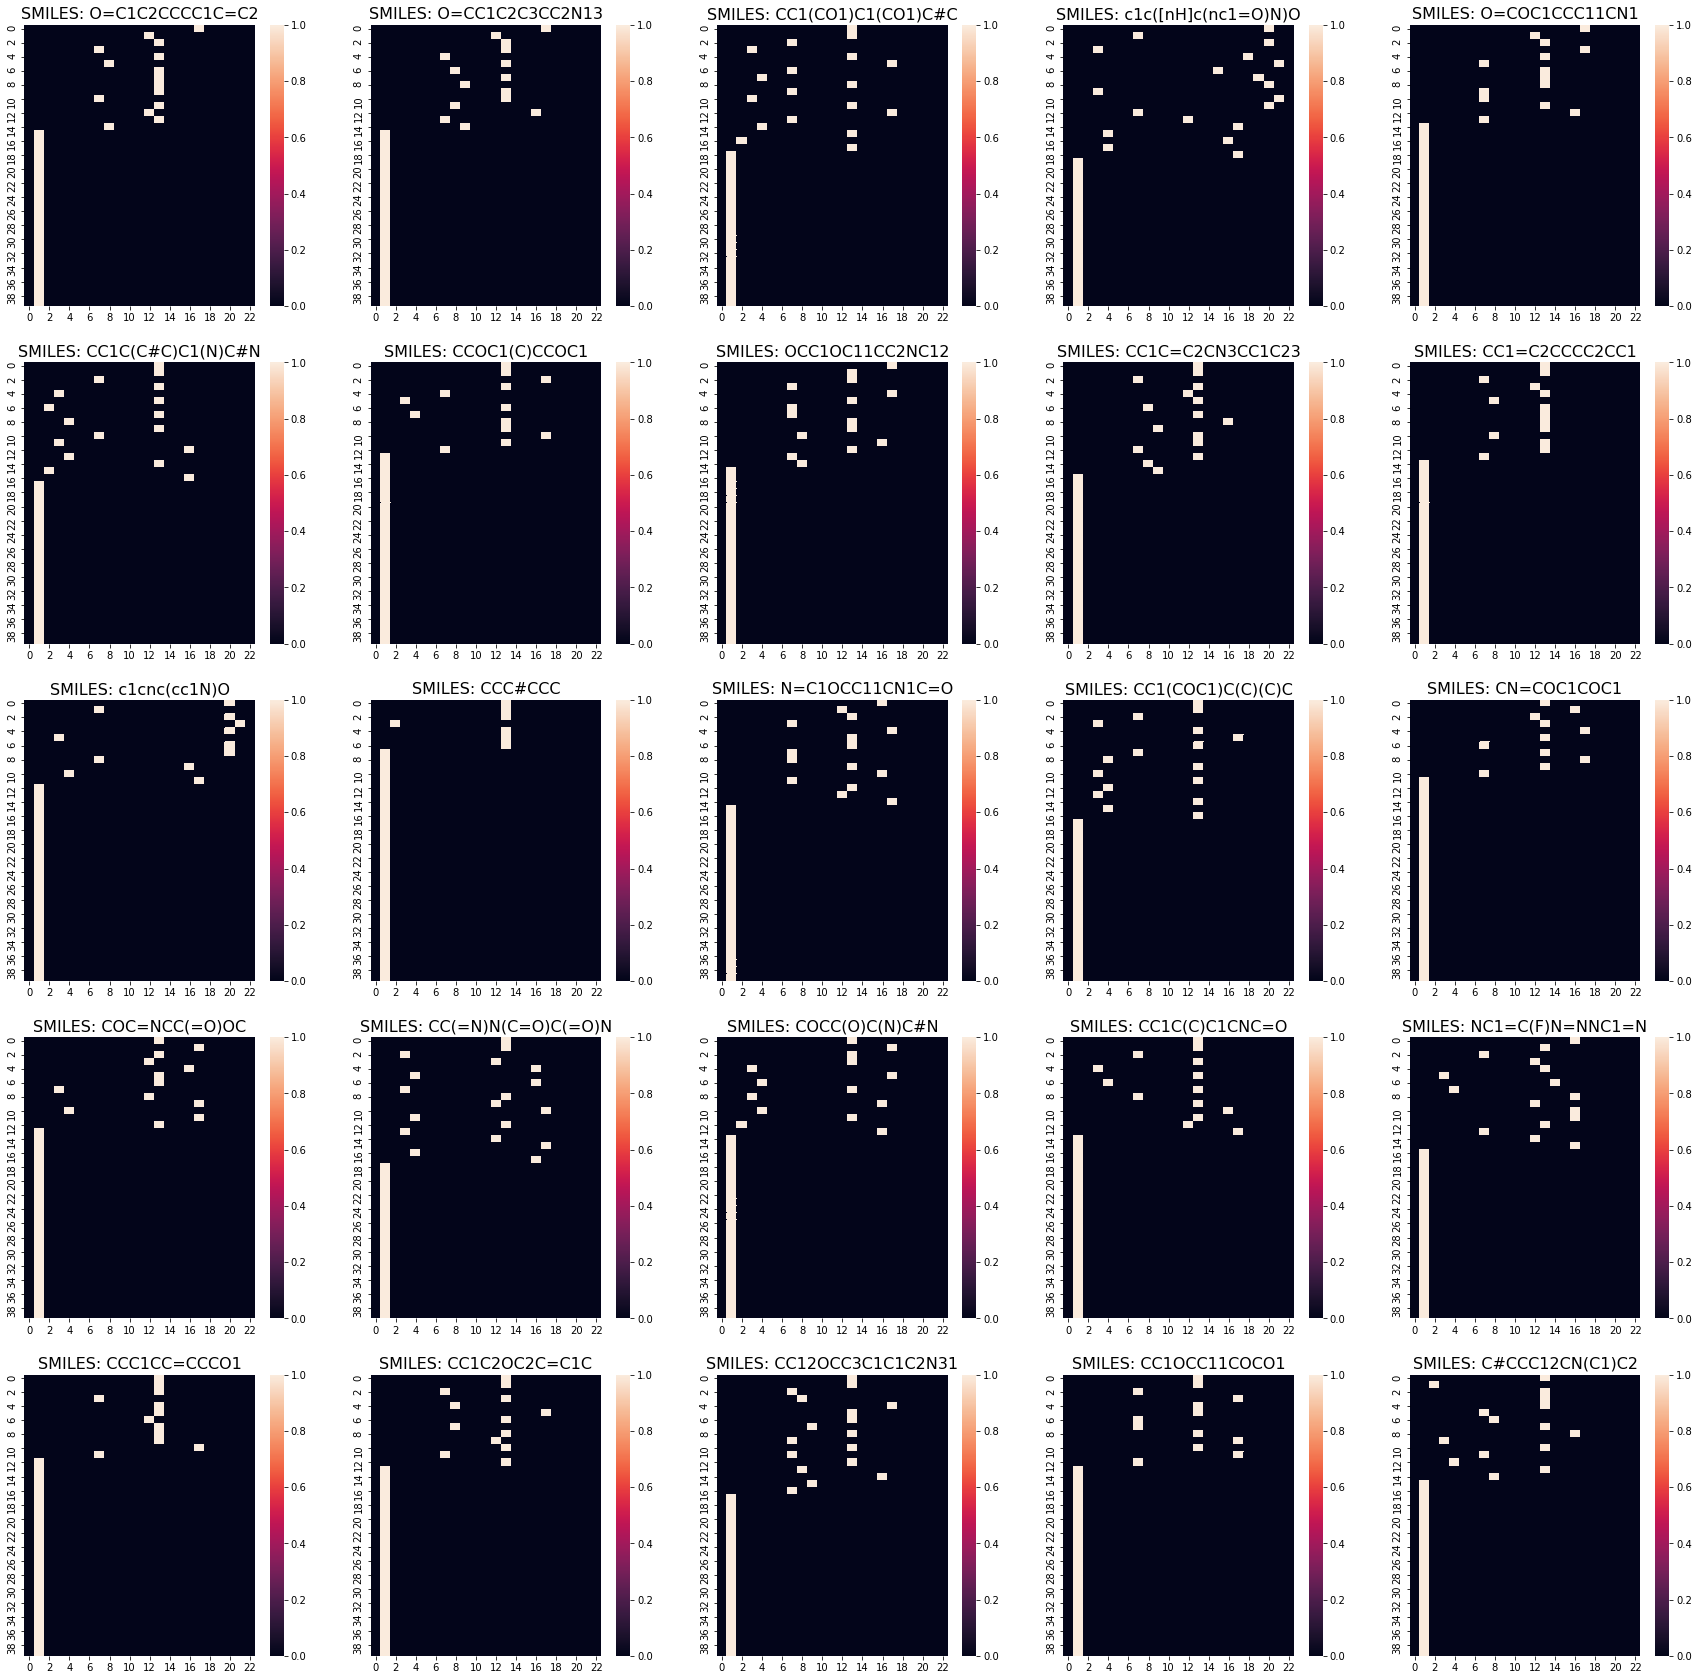

In [7]:
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(6*num_cols, 6*num_rows))
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    #plot_image(i, predictions, testLabels, testImages)
    #plt.figure(figsize=(30,30))
    #for i in range(25): #133785 
    #plt.subplot(5,5,i+1)
    plt.xticks([],fontsize=8)
    plt.yticks([],fontsize=8)
    plt.grid(True)
    #plt.xlabel(X_test(dataset.iloc[i])
    plt.xlabel('Character', fontsize=16)
    #plt.ylabel(X_test(dataset.iloc[i])
    plt.ylabel('Position in SMILES String', fontsize=16)
    #X_test[i] = X_test[i]("Position in SMILES String", "Character")
    plt.title(f"SMILES: {dataset.iloc[i]['smiles']}", fontsize=16)
    #plt.plot(range(num_images), label=f"SMILES: {dataset.iloc[i]['smiles']}")
    #plt.legend()
    #sns.heatmap(X_test[i])
    sns.heatmap(X_train[i])

    #plt.imshow(X_train[i], cmap=plt.cm.binary)
    #plt.xlabel(class_names[int(trainLabels[i])])
    #print(dataset.iloc[i]['smiles'])

    
#plt.imshow(X_train[index]) # By altering 'index' you will see another of the pictures imported
#plt.colorbar()
#plt.grid(False)
#print("Train Images Array shape:", trainImages.shape)
#print("Train Labels Array shape:", trainLabels.shape)
#print("Test Images Array shape:", testImages.shape)
#print("Test Labels Array shape:", testLabels.shape)

#index = 6986 #index runs from 0 to 138388
#sns.heatmap(X_train[index]) # This is a single training example -- note that it is a matrix, not a single vector!
#plt.xlabel('Character')
#plt.ylabel('Position in SMILES String')
#print(dataset.iloc[index]['smiles'])
#ax=plt.savefig('gdrive/MyDrive/Colab Notebooks/data/fig_smiles_character.png', dpi=600, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format=None,transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None, metadata=None)
#ax=plt.savefig('./homo_fig_smiles_character.png', dpi=600, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format=None,transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None, metadata=None)

#ax = sns.distplot(dataset["r2"], rug=True, rug_kws={"color": "g"},kde_kws={"color": "k", "lw": 3, "label": "KDE"},hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "r"})
#ax=plt.savefig('./homo_X_test.png', dpi=600, facecolor='w', edgecolor='w',orientation='landscape', papertype='a4', format=None, transparent=False, bbox_inches=None, pad_inches=None, frameon=None, metadata=None, annot=True, fmt="d")
ax=plt.savefig('./mu_X_train.png', dpi=600, facecolor='w', edgecolor='w',orientation='landscape', papertype='a4', format=None, transparent=False, bbox_inches=None, pad_inches=None, frameon=None, metadata=None, annot=True, fmt="d")


# <ins>Supervised CNN model for predicting solubility</ins>

In this section, we will set up a convolutional neural network to predict solubility using one-hot SMILES as input. A convolutional neural network is a machine learning model that is commonly used to classify images, and you can learn more about them [here](https://en.wikipedia.org/wiki/Convolutional_neural_network).

### Define model structure

First, we will create the model structure, starting with the input layer. As described above, each training example is a 40x31 matrix, which is the shape we pass to the Input layer in Keras.

In [8]:
# Define the input layer
# NOTE: We feed in a sequence here! We're inputting up to max_smiles_chars characters, 
# and each character is an array of length charset_length


smiles_input = Input(shape=(max_smiles_chars, charset_length), name="SMILES-Input")

Next we will define the convolution layers where each layer attempts to learn certain features of the images, such as edges and corners. The input to each layer (a matrix) is transformed via convolution operations, which are element by element multiplications of the input matrix and a filter matrix. The convolutional layer learns the filter matrix that will best identify unique features of the image. You can learn more about convolution operations and the math behind convolutional neural networks [here](https://towardsdatascience.com/gentle-dive-into-math-behind-convolutional-neural-networks-79a07dd44cf9).

In [9]:
# Set parameters for convolutional layers 
num_conv_filters = 16
kernel_size = 3
#kernel_init = initializers.RandomNormal(seed=0)
#bias_init = initializers.Zeros()
init_weights = initializers.glorot_normal(seed=0)

# Define the convolutional layers
# Multiple convolutions in a row is a common architecture (but there are many "right" choices here)
conv_1_func = Conv1D(
    filters=num_conv_filters, # What is the "depth" of the convolution? How many times do you look at the same spot?
    kernel_size=kernel_size, # How "wide" of a spot does each filter look at?
    name="Convolution-1",
    activation="relu", # This is a common activation function: Rectified Linear Unit (ReLU)
    kernel_initializer=init_weights #This defines the initial values for the weights
)
conv_2_func = Conv1D(
    filters=num_conv_filters, 
    kernel_size=kernel_size, 
    name="Convolution-2",
    activation="relu",
    kernel_initializer=init_weights
)
conv_3_func = Conv1D(
    filters=num_conv_filters, 
    kernel_size=kernel_size, 
    name="Convolution-3",
    activation="relu",
    kernel_initializer=init_weights
)
conv_4_func = Conv1D(
    filters=num_conv_filters, 
    kernel_size=kernel_size,
    name="Convolution-4",
    activation="relu",
    kernel_initializer=init_weights
)

# strides and paddind can be added in the convolution netowrk
# strides=2, padding="same"

The four convolution layers defined above will attempt to learn features of the SMILES string (represented as a 40x31 matrix) that are relevant to predicting the solubility. To get a numerical prediction, we now flatten the output of the convolution and pass it to a set of regular `Dense` layers, the last layer predicting one value for the solubility.

In [10]:
# Define layer to flatten convolutions
flatten_func = Flatten(name="Flattened-Convolutions")

# Define the activation function layer
hidden_size = 32
dense_1_func = Dense(hidden_size, activation="relu", name="Fully-Connected", kernel_initializer=init_weights)

# Add a Dense layer with a L1 activity regularizer
#dense_1_func = Dense(hidden_size, activation="relu", name="Fully-Connected", activity_regularizer=regularizers.l1(10e-5), kernel_initializer=init_weights)

# Define output layer -- it's only one dimension since it is regression
output_size = 1
output_mobility_func = Dense(output_size, activation="linear", name="Log-lumo", kernel_initializer=init_weights)




Now that we have defined all the layers, we will connect them together to make a graph:

In [11]:
# connect the CNN graph together
conv_1_fwd = conv_1_func(smiles_input)
conv_2_fwd = conv_2_func(conv_1_fwd)
conv_3_fwd = conv_3_func(conv_2_fwd)
conv_4_fwd = conv_4_func(conv_3_fwd)
flattened_convs = flatten_func(conv_4_fwd)
dense_1_fwd = dense_1_func(flattened_convs)
output_mobility_fwd = output_mobility_func(flattened_convs)

Instructions for updating:
Colocations handled automatically by placer.


### View model structure and metadata

Now the model is ready to train! But first we will define the model as `solubility_model` and compile it, then view some information on the model using the [keras2ascii](https://github.com/stared/keras-sequential-ascii) tool, which visually represents the layers in our model.

In [12]:
# create model
mobility_model = Model(
            inputs=[smiles_input],
            outputs=[output_mobility_fwd]
)
mae_st = []
# compile model
#optimizer = optimizers.RMSprop(0.002) # Root Mean Squared Propagation
# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy

# loss= mse, mae
# loss= categorical_crossentropy
#loss='sparse_categorical_crossentropy'
#loss='binary_crossentropy'
#metrics=['accuracy', 'binary_crossentropy']
#metrics=['accuracy']
mobility_model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)
mobility_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SMILES-Input (InputLayer)    (None, 40, 23)            0         
_________________________________________________________________
Convolution-1 (Conv1D)       (None, 38, 16)            1120      
_________________________________________________________________
Convolution-2 (Conv1D)       (None, 36, 16)            784       
_________________________________________________________________
Convolution-3 (Conv1D)       (None, 34, 16)            784       
_________________________________________________________________
Convolution-4 (Conv1D)       (None, 32, 16)            784       
_________________________________________________________________
Flattened-Convolutions (Flat (None, 512)               0         
_________________________________________________________________
Log-lumo (Dense)             (None, 1)                 513       
Total para

In [13]:
#!pip install keras_sequential_ascii
from keras_sequential_ascii import keras2ascii
# view model as a graph
keras2ascii(mobility_model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     40   23
          InputLayer     |   -------------------         0     0.0%
                       #####     40   23
              Conv1D    \|/  -------------------      1120    28.1%
                relu   #####     38   16
              Conv1D    \|/  -------------------       784    19.7%
                relu   #####     36   16
              Conv1D    \|/  -------------------       784    19.7%
                relu   #####     34   16
              Conv1D    \|/  -------------------       784    19.7%
                relu   #####     32   16
             Flatten   ||||| -------------------         0     0.0%
                       #####         512
               Dense   XXXXX -------------------       513    12.9%
                       #####           1


### Train CNN

Now we will train our CNN solubility model to the training data! During training, we will see metrics printed after each epoch such as test/train loss (both as Mean Squared Error (MSE) and Mean Absolute Error (MAE)).

In [14]:
#logdir="mobility_logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
mae_st = []
history = mobility_model.fit(
    X_train, # Inputs
    Y_train, # Outputs
    epochs=20, # How many times to pass over the data
    batch_size=64, # How many data rows to compute at once
    verbose=1,
    validation_data=(X_test, Y_test),
    #callbacks=[tensorboard_callback] # You would usually use more splits of the data if you plan to tune hyperparams
)
#print('mse')
#print('mae')
mobility_model.save(os.path.expanduser('./mu_cnn_model.h5'))

Instructions for updating:
Use tf.cast instead.
Train on 120500 samples, validate on 13385 samples
Epoch 1/20
120500/120500 [==============================] - 852s 7ms/step - loss: 1.4583 - mean_absolute_error: 0.8986 - val_loss: 1.1721 - val_mean_absolute_error: 0.8070
Epoch 2/20
120500/120500 [==============================] - 272s 2ms/step - loss: 1.1544 - mean_absolute_error: 0.7829 - val_loss: 1.0937 - val_mean_absolute_error: 0.7703
Epoch 3/20
120500/120500 [==============================] - 333s 3ms/step - loss: 1.0963 - mean_absolute_error: 0.7605 - val_loss: 1.1138 - val_mean_absolute_error: 0.7791
Epoch 4/20
120500/120500 [==============================] - 397s 3ms/step - loss: 1.0553 - mean_absolute_error: 0.7451 - val_loss: 1.0367 - val_mean_absolute_error: 0.7425
Epoch 5/20
120500/120500 [==============================] - 393s 3ms/step - loss: 1.0310 - mean_absolute_error: 0.7359 - val_loss: 0.9893 - val_mean_absolute_error: 0.7252
Epoch 6/20
120500/120500 [===============

Let's view the learning curve for the trained model.

This code will generate a plot where we show the test and train errors (MSE) as a function of epoch (one pass of all training examples through the NN).

The learning curve will tell us if the model is overfitting or underfitting.

findfont: Font family ['Arial Narrow'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial narrow'] not found. Falling back to DejaVu Sans.


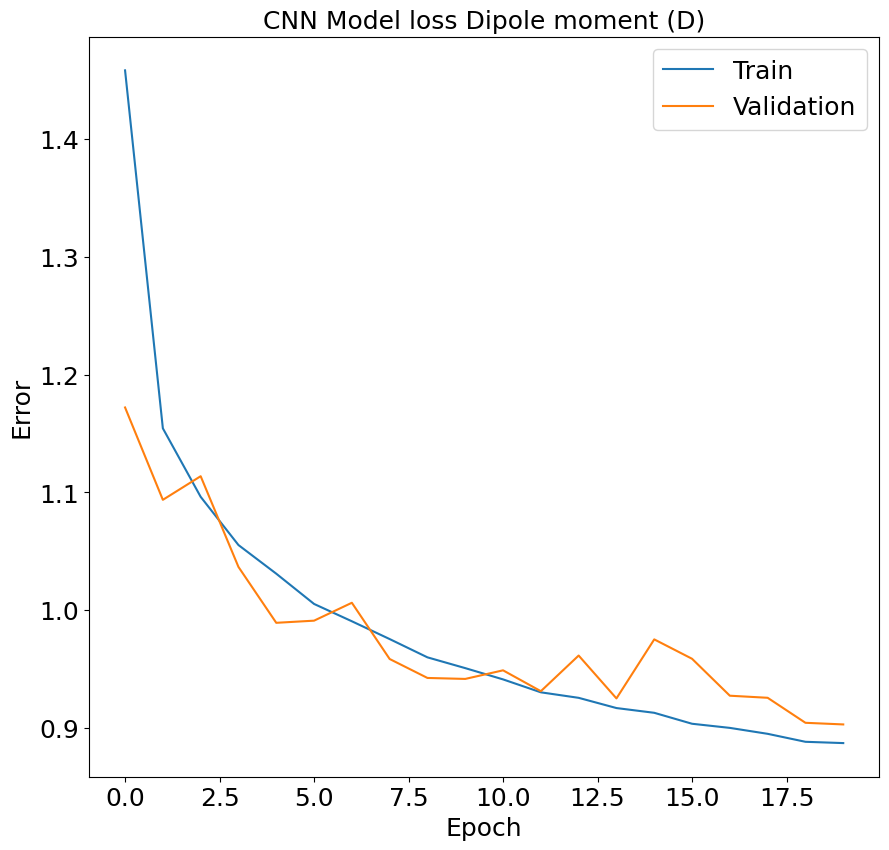

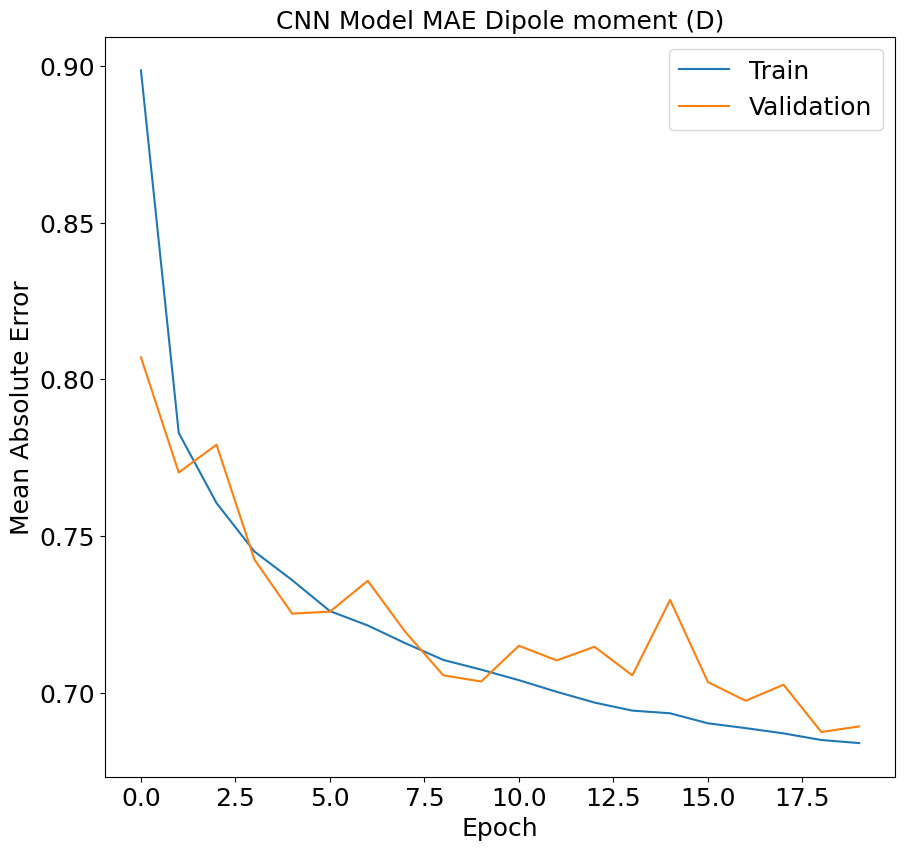

In [15]:
# plot the learning curve 
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.16, bottom=0.16, right=0.95, top=0.90)
plt.rc('font', family='Arial narrow')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model loss Dipole moment (D)', fontname='Arial Narrow', size=18) #pad=12
plt.ylabel('Error',fontname='Arial Narrow', size=18)
plt.xlabel('Epoch',fontname='Arial Narrow', size=18)
#plt.xlim(0,20)
#plt.ylim(0,20)
plt.legend(['Train', 'Validation',], loc='upper right')
# te = '%.2f' % mean_absolute_error
# tr = '%.2f' % mse_X_test
# plt.text(4.3, 0.8, 'Test_rmse = ', c='r', fontsize=16)
# plt.text(7.4, 0.8, te, c='r', fontsize=16)
# plt.text(8.5, 0.8, 'eV', c='r', fontsize=16)
# plt.text(4.2, 0.1, 'Train_rmse = ', c='r', fontsize=16)
# plt.text(7.4, 0.1, tr, c='r', fontsize=16)
# plt.text(8.5, 0.1, 'eV', c='r', fontsize=16)
plt.savefig('./mu_cnn_X_training_loss.png', dpi=600, facecolor='w', edgecolor='w', scale=1, width=600, height=350)
plt.show()


# plot the learning curve 
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.16, bottom=0.16, right=0.95, top=0.90)
plt.rc('font', family='Arial narrow')
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('CNN Model MAE Dipole moment (D)', fontname='Arial Narrow', size=18) #pad=12
plt.ylabel('Mean Absolute Error',fontname='Arial Narrow', size=18)
plt.xlabel('Epoch',fontname='Arial Narrow', size=18)
#plt.xlim(0,20)
#plt.ylim(0,2)
plt.legend(['Train', 'Validation',], loc='upper right')
# te = '%.2f' % mean_absolute_error
# tr = '%.2f' % mse_X_test
# plt.text(4.3, 0.8, 'Test_rmse = ', c='r', fontsize=16)
# plt.text(7.4, 0.8, te, c='r', fontsize=16)
# plt.text(8.5, 0.8, 'eV', c='r', fontsize=16)
# plt.text(4.2, 0.1, 'Train_rmse = ', c='r', fontsize=16)
# plt.text(7.4, 0.1, tr, c='r', fontsize=16)
# plt.text(8.5, 0.1, 'eV', c='r', fontsize=16)
plt.savefig('./mu_cnn_X_training_mae.png', dpi=600, facecolor='w', edgecolor='w', scale=1, width=600, height=350)
plt.show()
# plot the learning curve 

### Use CNN to make solubility predictions
Now that we've trained our model, we can use it to make solubility predictions for any SMILES string! We just have to convert the SMILES string to 1-hot representation, then feed it to the `solubility_model` 

In [16]:
example_smiles = ['CC(C)CCCCO(C)N','CCC(C)CCC(C)OC','CC=CC1CCC1=O','CCOC()CCC','CC1(CC1OC)C#C'  ]
#'CC(C)CCCCO(C)N','CCC(C)CCC(C)OC','CC=CC1CCC1=O','CCOC()CCC','CC1(CC1OC)C#C'
#'Cc1cc(c1CCO)C#N','CCCCCCCCCC#C', 'CCC(C)CCC(C)C#C' ,'OCCCCC', 'CCC(C)(=O)C#C#N' , 'CCCCCCC#CCC' 'CC(=O)C=C(N)F', 'CCC', 'cccc', ''                   
for smiles in example_smiles:
    predict_test_input = smiles_to_onehots([smiles], charset, max_smiles_chars)
    mobility_prediction = mobility_model.predict(predict_test_input)[0][0]
    print(f'The predicted Dipole moment (D) for SMILES {smiles} is {mobility_prediction}')

The predicted Dipole moment (D) for SMILES CC(C)CCCCO(C)N is 1.6577367782592773
The predicted Dipole moment (D) for SMILES CCC(C)CCC(C)OC is 1.0040388107299805
The predicted Dipole moment (D) for SMILES CC=CC1CCC1=O is 2.3586273193359375
The predicted Dipole moment (D) for SMILES CCOC()CCC is 0.5639141798019409
The predicted Dipole moment (D) for SMILES CC1(CC1OC)C#C is 1.3464932441711426


We can now make a parity plot comparing the CNN model predictions to the ground truth data

findfont: Font family ['Arial narrow'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial Narrow'] not found. Falling back to DejaVu Sans.


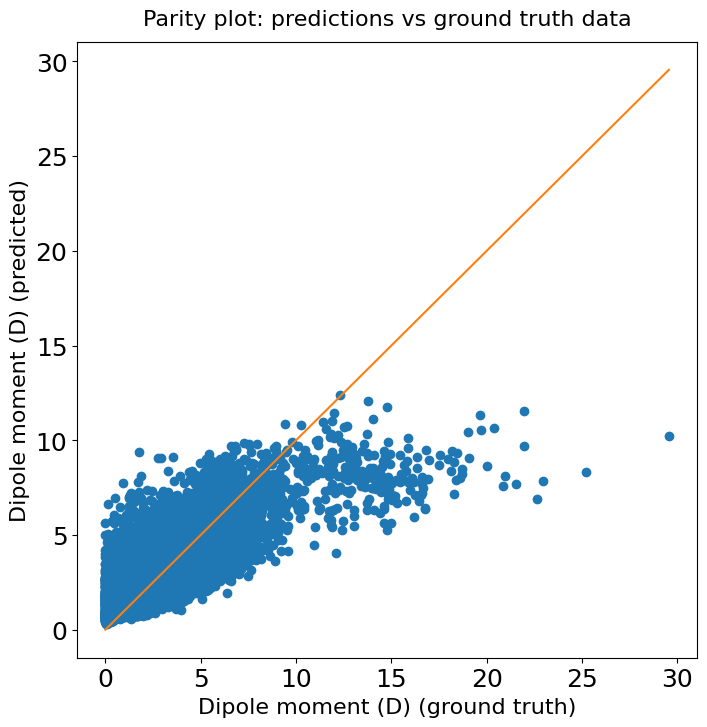

In [17]:
preds = mobility_model.predict(X_train)
x_y_line = np.linspace(min(Y_train.flatten()), max(Y_train.flatten()), 500)
plt.figure(figsize=(8,8))
#plt.subplots_adjust(left=0.16, bottom=0.16, right=0.95, top=0.90)
#plt.rc('font', family='Arial narrow')

plt.plot(Y_train.flatten(), preds.flatten(), 'o', label='predictions')
plt.plot(x_y_line, x_y_line, label='y=x')
plt.xlabel("Dipole moment (D) (ground truth)", fontname='Arial Narrow', size=16)
plt.ylabel("Dipole moment (D) (predicted)", fontname='Arial Narrow', size=16)
plt.title('Parity plot: predictions vs ground truth data', fontsize=16, pad=12)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
#a  = [-175,0,125]
#b = [-175,0,125]
#plt.plot(b, a, c='k', ls='-')
#plt.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':16})
plt.savefig('./mu_cnn_X_predict.png', dpi=600, facecolor='w', edgecolor='w', scale=1)

### Save model
We can save/load this model for future use, using the `save()` and `load_model()` functions from Keras.

In [18]:
# Save the model
mobility_model.save("mu_mobility_model.hdf5")

# Load it back
loaded_model = load_model("mu_mobility_model.hdf5")

# <ins>VAE model for generating SMILES strings</ins>
In this section, we will set up a variational autoencoder to encode and decode SMILES strings. An autoencoder is a model that encodes the input to the model into a set of variables (known as encoded or 'latent variables'), which are then decoded to recover the original input. A variational autoencoder is an advanced version of an autoencoder where the encoded/latent variables are learnt as probability distributions rather than discrete values. You can learn more about autoencoders and variational autoencoders [here](https://www.jeremyjordan.me/variational-autoencoders/) and [here](https://www.jeremyjordan.me/autoencoders/).

### Define model structure

We'll need to define some new layers for this model, but we can also reuse old ones! (You will see this when we connect the model together.)

In [19]:
# hidden activation layer
hidden_size = 16
dense_1_func = Dense(hidden_size, activation="relu", name="Fully-Connected-Latent", kernel_initializer=init_weights)

Now we'll define the layers to map to the latent space. We then define a sampling function that samples from a gaussian distribution to return the sampled latent variables.

In [20]:
# VAE sampling 
# K.shape= Keras.shape
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal((batch, dim), mean=0.0, stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon # mu + sigma*epsilon yields a shifted, rescaled gaussian, 
                                                     # if epsilon is the standard gaussian
#latent space.last hidden_size = 16 to latent_dim = 32 
# encode to latent space
latent_dim = 32 
z_mean_func = Dense(latent_dim, name='z_mean')
log_z_func = Dense(latent_dim, name='z_log_var')
z_func = Lambda(sampling, name='z_sample')
#print(z_mean_func)
#print(log_z_func)
#print(z_func)
#z = Lambda(sampling)([z_mean, z_log_var])

Now we'll define the RNN (Recurrent Neural Network) layers for decoding SMILES from latent space values. Recurrent neural networks are known to perform well for learning a time series of data, where each cell of the recurrent network can learn from the previous cells, thus learning time dependencies in the data. This RNN uses Gated Recurrent Units as cells and you can learn more about recurrent neural networks and Gated Recurrent Units [here](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be).

In [21]:
# this repeat vector just repeats the input `max_smiles_chars` times 
# so that we get a value for each character of the SMILES string
repeat_1_func = RepeatVector(max_smiles_chars, name="Repeat-Latent-1")

# RNN decoder
rnn_size = 32
gru_1_func = GRU(rnn_size, name="RNN-decoder-1", return_sequences=True, kernel_initializer=init_weights)
gru_2_func = GRU(rnn_size, name="RNN-decoder-2", return_sequences=True, kernel_initializer=init_weights)
gru_3_func = GRU(rnn_size, name="RNN-decoder-3", return_sequences=True, kernel_initializer=init_weights)

Finally we'll define the output, which should map to the original SMILES input:

In [22]:
output_func = TimeDistributed(
    Dense(charset_length, activation="softmax", name="SMILES-Output", kernel_initializer=init_weights), 
    name="Time-Distributed"
)

Now that we have defined all the layers, we will connect them together to make a graph:

In [23]:
# connecting the VAE model as a graph

# cnn encoder layers
conv_1_fwd = conv_1_func(smiles_input)
conv_2_fwd = conv_2_func(conv_1_fwd)
conv_3_fwd = conv_3_func(conv_2_fwd)
conv_4_fwd = conv_4_func(conv_3_fwd)

# flattening
flattened_convs = flatten_func(conv_4_fwd)
dense_1_fwd = dense_1_func(flattened_convs)

# latent space
z_mean = z_mean_func(dense_1_fwd)
z_log_var = log_z_func(dense_1_fwd)
z = z_func([z_mean, z_log_var])

# rnn decoder layers
repeat_1_fwd = repeat_1_func(z)
gru_1_fwd = gru_1_func(repeat_1_fwd)
gru_2_fwd = gru_2_func(gru_1_fwd)
gru_3_fwd = gru_3_func(gru_2_fwd)
smiles_output = output_func(gru_3_fwd)

### View model structure and metadata
Now the model is ready to train! But first we will compile the VAE model, then view model metadata, again using the [keras2ascii](https://github.com/stared/keras-sequential-ascii) tool. To compile the model, we will need to define our own VAE loss function.

In [24]:
# vae loss function -- reconstruction loss (cross entropy) plus KL divergence loss against a Gaussian prior
# Intuitive meaning for this loss function: "Reconstruct the data but stay close to a Gaussian"
def vae_loss(x_input, x_predicted):
    reconstruction_loss = K.sum(binary_crossentropy(x_input, x_predicted), axis=-1)
    reconstruction_loss *= input_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

# create model
vae_model = Model(
            inputs=[smiles_input],
            outputs=[smiles_output]
)

# compile model
vae_model.compile(
    optimizer="adam",
    loss=vae_loss,
    metrics=["accuracy"]
)
vae_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
SMILES-Input (InputLayer)       (None, 40, 23)       0                                            
__________________________________________________________________________________________________
Convolution-1 (Conv1D)          (None, 38, 16)       1120        SMILES-Input[0][0]               
__________________________________________________________________________________________________
Convolution-2 (Conv1D)          (None, 36, 16)       784         Convolution-1[1][0]              
__________________________________________________________________________________________________
Convolution-3 (Conv1D)          (None, 34, 16)       784         Convolution-2[1][0]              
__________________________________________________________________________________________________
Convolutio

In [25]:
# view model as a graph
keras2ascii(vae_model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     40   23
          InputLayer     |   -------------------         0     0.0%
                       #####     40   23
              Conv1D    \|/  -------------------      1120     3.5%
                relu   #####     38   16
              Conv1D    \|/  -------------------       784     2.4%
                relu   #####     36   16
              Conv1D    \|/  -------------------       784     2.4%
                relu   #####     34   16
              Conv1D    \|/  -------------------       784     2.4%
                relu   #####     32   16
             Flatten   ||||| -------------------         0     0.0%
                       #####         512
               Dense   XXXXX -------------------      8208    25.5%
                relu   #####          16
               Dense   XXXXX -------------------       544     1.7%
                       #####          32
             

### Train VAE

When training our VAE, we will see metrics printed after each epoch such as test/train loss and accuracy values.

In [26]:
# Reset model and set all layers are trainable
vae_model.reset_states()
for layer in vae_model.layers:
    layer.trainable = True

# fit model to training data
history = vae_model.fit(
    x=X_train,
    y=X_train,
    epochs=20,
    validation_data=(X_test, X_test),
    batch_size=64,
    verbose=1
)

Train on 120500 samples, validate on 13385 samples
Epoch 1/20
120500/120500 [==============================] - 1620s 13ms/step - loss: 1863.1316 - acc: 0.7605 - val_loss: 1637.6300 - val_acc: 0.7761
Epoch 2/20
120500/120500 [==============================] - 1459s 12ms/step - loss: 1531.1556 - acc: 0.7878 - val_loss: 1443.1591 - val_acc: 0.8026
Epoch 3/20
120500/120500 [==============================] - 1361s 11ms/step - loss: 1356.6369 - acc: 0.8150 - val_loss: 1291.8859 - val_acc: 0.8254
Epoch 4/20
120500/120500 [==============================] - 1570s 13ms/step - loss: 1233.8086 - acc: 0.8329 - val_loss: 1178.0115 - val_acc: 0.8405
Epoch 5/20
120500/120500 [==============================] - 1588s 13ms/step - loss: 1131.6731 - acc: 0.8486 - val_loss: 1132.1550 - val_acc: 0.8479
Epoch 6/20
120500/120500 [==============================] - 1478s 12ms/step - loss: 1056.0582 - acc: 0.8617 - val_loss: 1027.6680 - val_acc: 0.8663
Epoch 7/20
120500/120500 [==============================] - 1

Let's view the learning curve for the trained model. 

This code will generate a plot where we show the test and train errors as a function of epoch (one forward pass and one backward pass of all training examples through the NN).

The learning curve will tell us if the model is overfitting or underfitting. 

findfont: Font family ['Arial narrow'] not found. Falling back to DejaVu Sans.


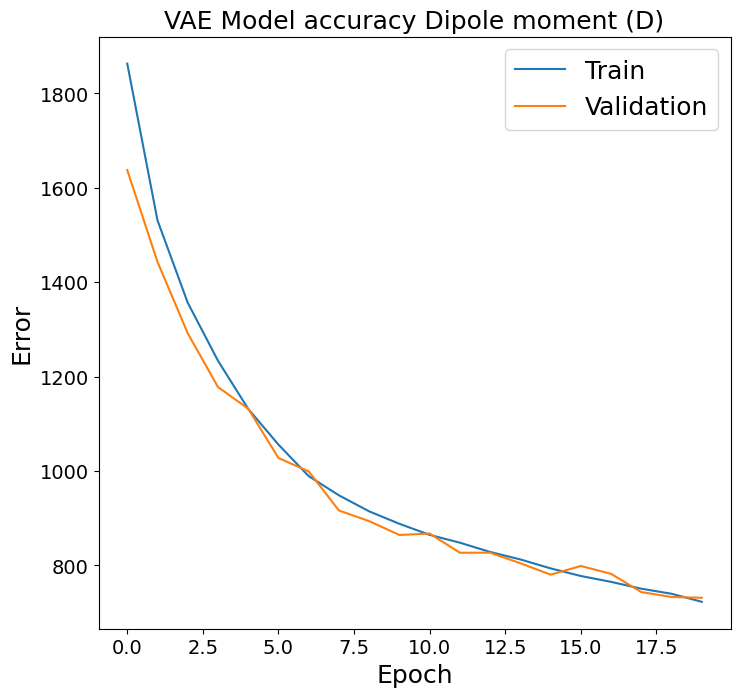

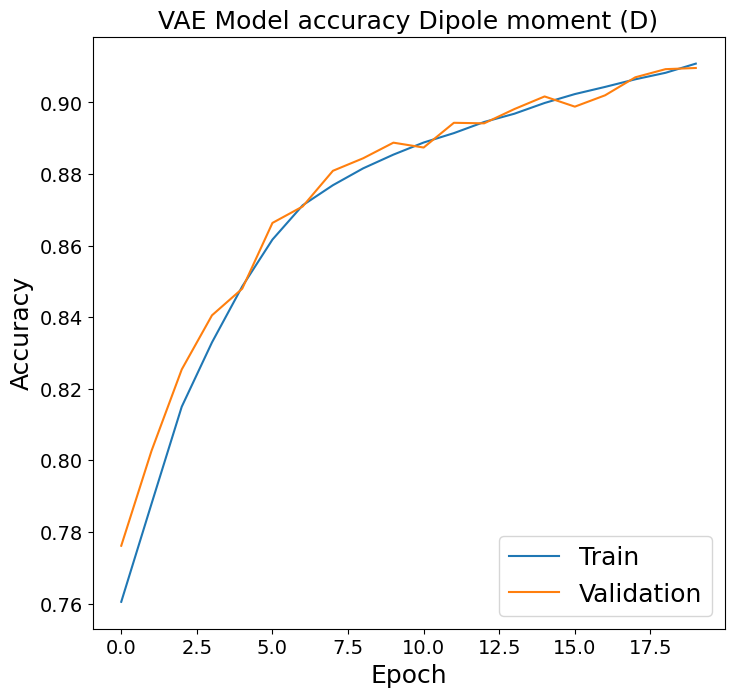

In [27]:
# plot the learning curve 
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0.16, bottom=0.16, right=0.95, top=0.90)
plt.rc('font', family='Arial narrow')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VAE Model accuracy Dipole moment (D)', fontname='Arial Narrow', size=18) #pad=12
plt.ylabel('Error',fontname='Arial Narrow', size=18)
plt.xlabel('Epoch',fontname='Arial Narrow', size=18)
#plt.xlim(0,20)
#plt.ylim(800,2000)
plt.legend(['Train', 'Validation',], loc='upper right')
# te = '%.2f' % mean_absolute_error
# tr = '%.2f' % mse_X_test
# plt.text(4.3, 0.8, 'Test_rmse = ', c='r', fontsize=16)
# plt.text(7.4, 0.8, te, c='r', fontsize=16)
# plt.text(8.5, 0.8, 'eV', c='r', fontsize=16)
# plt.text(4.2, 0.1, 'Train_rmse = ', c='r', fontsize=16)
# plt.text(7.4, 0.1, tr, c='r', fontsize=16)
# plt.text(8.5, 0.1, 'eV', c='r', fontsize=16)
plt.savefig('./mu_vae_X_training_loss.png', dpi=600, facecolor='w', edgecolor='w', scale=1, width=600, height=350)
plt.show()
# plot the learning curve 


# plot the learning curve 
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0.16, bottom=0.16, right=0.95, top=0.90)
plt.rc('font', family='Arial narrow')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('VAE Model accuracy Dipole moment (D)', fontname='Arial Narrow', size=18) #pad=12
plt.ylabel('Accuracy',fontname='Arial Narrow', size=18)
plt.xlabel('Epoch',fontname='Arial Narrow', size=18)
#plt.xlim(0,20)
#plt.ylim(800,2000)
plt.legend(['Train', 'Validation',], loc='lower right')
# te = '%.2f' % mean_absolute_error
# tr = '%.2f' % mse_X_test
# plt.text(4.3, 0.8, 'Test_rmse = ', c='r', fontsize=16)
# plt.text(7.4, 0.8, te, c='r', fontsize=16)
# plt.text(8.5, 0.8, 'eV', c='r', fontsize=16)
# plt.text(4.2, 0.1, 'Train_rmse = ', c='r', fontsize=16)
# plt.text(7.4, 0.1, tr, c='r', fontsize=16)
# plt.text(8.5, 0.1, 'eV', c='r', fontsize=16)
plt.savefig('./mu_vae_X_training_acc.png', dpi=600, facecolor='w', edgecolor='w', scale=1, width=600, height=350)
plt.show()
# plot the learning curve 


### Create a decoder model and use to generate SMILES from noise

Now that we have trained our VAE, we can use the decoding part of the VAE to generate SMILES strings! Let's start by defining our decoder model. Note that this model doesn't need to be compiled since we are not training this model.

In [28]:
# connect the decoder graph
decoder_input = Input(shape=(latent_dim,), name="decoder_input")
decoder_repeat_1_fwd = repeat_1_func(decoder_input)
decoder_gru_1_fwd = gru_1_func(decoder_repeat_1_fwd)
decoder_gru_2_fwd = gru_2_func(decoder_gru_1_fwd)
decoder_gru_3_fwd = gru_3_func(decoder_gru_2_fwd)
decoder_smiles_output = output_func(decoder_gru_3_fwd)

# define decoder model
decoder_model = Model(
    inputs=[decoder_input],
    outputs=[decoder_smiles_output]
)
decoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 32)                0         
_________________________________________________________________
Repeat-Latent-1 (RepeatVecto (None, 40, 32)            0         
_________________________________________________________________
RNN-decoder-1 (GRU)          (None, 40, 32)            6240      
_________________________________________________________________
RNN-decoder-2 (GRU)          (None, 40, 32)            6240      
_________________________________________________________________
RNN-decoder-3 (GRU)          (None, 40, 32)            6240      
_________________________________________________________________
Time-Distributed (TimeDistri (None, 40, 23)            759       
Total params: 19,479
Trainable params: 19,479
Non-trainable params: 0
_________________________________________________________________


In [29]:
# view decoder graph. this should look like a subset of the VAE graph.
keras2ascii(decoder_model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####          32
          InputLayer     |   -------------------         0     0.0%
                       #####          32
        RepeatVector   ????? -------------------         0     0.0%
                       #####     40   32
                 GRU   LLLLL -------------------      6240    32.0%
                tanh   #####     40   32
                 GRU   LLLLL -------------------      6240    32.0%
                tanh   #####     40   32
                 GRU   LLLLL -------------------      6240    32.0%
                tanh   #####     40   32
     TimeDistributed   ????? -------------------       759     3.9%
                       #####     40   23


Now let's generate SMILES strings! First we will randomly sample from a unit gaussian distribution, feed the random samples into the decoder model, and take the output of the decoder model and convert it back into SMILES characters. Don't be surprised to see strange SMILES strings! We used a very small dataset, and did not train for very long.

In [30]:
for x in range(20):
    
    # draw from a unit gaussian 
    decoder_test_input = np.random.normal(0, 1, latent_dim).reshape(1, latent_dim)
    decoder_test_output = decoder_model.predict(decoder_test_input)
    
    decoded_one_hots = np.argmax(decoder_test_output, axis = 2)

    SMILES = ''
    for char_idx in decoded_one_hots[0]:
        if charset[char_idx] in ["PAD", "NULL"]: 
            break # Stop decoding if you hit padding or an out-of-vocab character (NULL)
        
        SMILES = SMILES + charset[char_idx]

    print(SMILES)

CC1CCCCCC)=C=O
cccc
OC1
CC(C#O)(O)()C#N
CC(CO)OC==C=
CNCC(OCC2C2C1
CCC(CCCCCCCCO
CCC(O)CCCCC#N
CCC1OCCCO1
CC#C)))1CCOC
CCCC(=))CC1=F
C1=C1CC2CCN12
ccHH
CC(CCC1)C1CCC1
C1CC2C3CCCCCC12C
CCCC1OCCCC1
C
CCCCC=11(oo1O
CC1CCCCC(C=O
CCOC


### Save VAE and decoder models
We can save/load these models for future use, again using the `save()` and `load_model()` functions from Keras.

In [31]:
# save and load the decoder model 
decoder_model.save("mu_decoder_model.hdf5")
loaded_decoder_model = load_model("mu_decoder_model.hdf5")

# for VAEs, we must instantiate model w/ same architecture then load weights onto this model
vae_model.save_weights("mu_vae.hdf5")
loaded_vae_model = vae_model.load_weights("mu_vae.hdf5")